<div class="alert alert-block alert-success">
<h2>Import Necessary Libraries</h1>
</div>

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [2]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)

save_file('https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_train.csv', 'seattle_rain_train.csv')
save_file('https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_test.csv', 'seattle_rain_test.csv')

<div class="alert alert-block alert-success">
<p>Read in the data</p>
</div>

In [3]:
rain = pd.read_csv('seattle_rain_train.csv')
print(rain.head())
rain.shape

DATE  PRCP  TMAX  TMIN  RAIN  TMIDR  TRANGE  MONTH  SEASON  \
0  1948-01-30  0.03    47    30     1   38.5      17      1       1   
1  1948-01-31  0.21    35    27     1   31.0       8      1       1   
2  1948-02-01  0.03    39    30     1   34.5       9      2       1   
3  1948-02-02  0.00    43    26     0   34.5      17      2       1   
4  1948-02-03  0.20    38    26     1   32.0      12      2       1   

   TMRW_RAIN  TMRW_PRCP  YEST_RAIN  YEST_PRCP  SUM7_PRCP  SUM14_PRCP  \
0        1.0       0.21        1.0       0.22       0.35        0.56   
1        1.0       0.03        1.0       0.03       0.46        0.77   
2        0.0       0.00        1.0       0.21       0.49        0.80   
3        1.0       0.20        1.0       0.03       0.49        0.80   
4        1.0       0.14        0.0       0.00       0.69        1.00   

   SUM30_PRCP  
0        4.28  
1        4.02  
2        3.46  
3        3.04  
4        2.93  


(18964, 16)

<div class="alert alert-block alert-success">
<p>Choose relevent features (Ignore ID, Date, and TMRW_PRCP)</p>
</div>

In [4]:
target = 'TMRW_RAIN'
features = ['PRCP', 'TMAX', 'TMIN', 'RAIN', 'TMIDR', 'TRANGE', 'MONTH', 'SEASON', 'YEST_RAIN', 'YEST_PRCP', 'SUM7_PRCP', 'SUM14_PRCP', 'SUM30_PRCP']

<div class="alert alert-block alert-success">
<p>Split into train and validation set</p>
</div>

In [5]:
train_data, validation_data = train_test_split(rain, test_size=0.2)
test_data = pd.read_csv('seattle_rain_train.csv')

<div class="alert alert-block alert-success">
<p>See what the majority class is and that we can see what we should be more accurate than.</p>
</div>

In [6]:
len(rain[rain['TMRW_RAIN'] == 1]) / len(rain)

0.42491035646488085

<div class="alert alert-block alert-success">
<p>The majority in TMRW_RAIN was 0, appearing 58% of the time. We should be more accurate than that.</p>
</div>

<div class="alert alert-block alert-success">
<h1>Random Forest Classifier</h1>
<p>Starting with Random Forest Classifier. Use GridSearch to find best hyperparameters (takes a bit of time)</p>
</div>

In [7]:
max_depth = [1] + np.arange(5, 16, 5).tolist()
min_samples_leaf = [1] + np.arange(5, 21, 5).tolist()

hyperparameters = {'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

search = GridSearchCV(estimator=RandomForestClassifier(), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'max_depth': 15, 'min_samples_leaf': 20}


<div class="alert alert-block alert-success">
<p>Make graphs for accuracy of train and validation data</p>
</div>

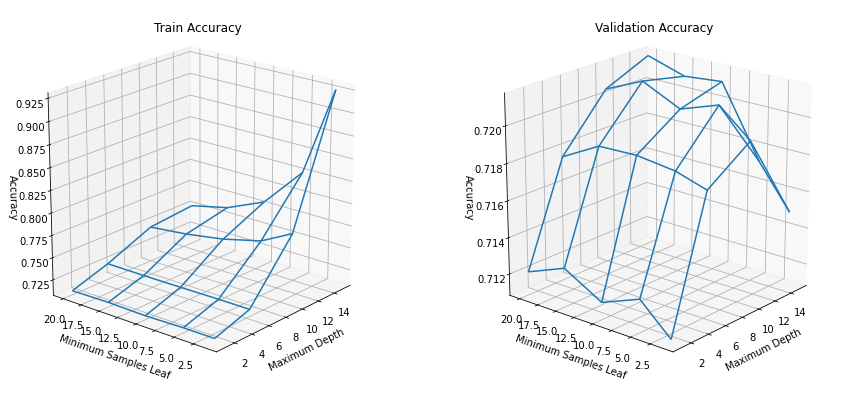

In [8]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

<div class="alert alert-block alert-success">
<p>Get accuracy score</p>
</div>

In [9]:
randomForest = RandomForestClassifier(max_depth=search.best_params_['max_depth'], min_samples_leaf=search.best_params_['min_samples_leaf'])
randomForest.fit(train_data[features], train_data[target])

predictions = randomForest.predict(validation_data[features])
print(accuracy_score(validation_data[target], predictions))

0.713683100448194


<div class="alert alert-block alert-success">
<p>Get probability and ROC score</p>
</div>

In [20]:
randomForest_probabilities = randomForest.predict_proba(validation_data[features])
randomForest_probabilities = randomForest_probabilities[:, 1]

<div class="alert alert-block alert-success">
<h1>KNearestNeighbor</h1>
</div>

In [11]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 20)

best_knn = KNeighborsClassifier(n_neighbors=1)
best_error = 0

for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train_data[features], train_data[target])

    train_predictions = knn.predict(train_data[features])
    validation_predictions = knn.predict(validation_data[features])

    train_score = accuracy_score(train_data[target], train_predictions)
    validation_score = accuracy_score(validation_data[target], validation_predictions)

    if validation_score > best_error:
        best_error = validation_score
        best_knn = knn

    print("{0} neighbor(s): Training: {1} Validation: {2}".format(n, train_score, validation_score))

1 neighbor(s): Training: 0.9998022543009689 Validation: 0.6153440548378593
2 neighbor(s): Training: 0.8038362665612023 Validation: 0.6366991827049828
3 neighbor(s): Training: 0.8035066903961505 Validation: 0.6485631426311627
4 neighbor(s): Training: 0.7636938896579 Validation: 0.6598998154495123
5 neighbor(s): Training: 0.7658690923472414 Validation: 0.664118112312154
6 neighbor(s): Training: 0.7470173357062817 Validation: 0.6604271025573425
7 neighbor(s): Training: 0.742337354162547 Validation: 0.659372528341682
8 neighbor(s): Training: 0.7337024586381913 Validation: 0.6696546269443712
9 neighbor(s): Training: 0.732120493045943 Validation: 0.6672818349591353
10 neighbor(s): Training: 0.7265176982400633 Validation: 0.6738729238070129
11 neighbor(s): Training: 0.7278360029002703 Validation: 0.6754547851305036
12 neighbor(s): Training: 0.7232878518225562 Validation: 0.6794094384392302
13 neighbor(s): Training: 0.7228264451914838 Validation: 0.6780912206696547
14 neighbor(s): Training: 0.

<div class="alert alert-block alert-success">
<p>Not very accurate...</p>
<p>Get probabilities for ROC and AUC later</p>
</div>

In [21]:
knn_probabilities = best_knn.predict_proba(validation_data[features])
knn_probabilities = knn_probabilities[:, 1]

<div class="alert alert-block alert-success">
<h1>Logistic Regression</h1>
</div>

<div class="alert alert-block alert-success">
<h2>Logistic Regression with L2 Regression</h2>
</div>

<div class="alert alert-block alert-success">
<p>Testing with different l2 penalties</p>
</div>

In [13]:
l2_penalties = [1e-4,1e-3,1e-2,1e-1, 1, 4,10, 1e2, 1e3, 1e5, 1e6]

for l2_penalty in l2_penalties:
    model = LogisticRegression(penalty='l2', random_state=1, fit_intercept=False, C=1/l2_penalty, max_iter=300).fit(train_data[features], train_data[target])
    predicted_vals = model.predict(validation_data[features])
    model_accuracy = accuracy_score(validation_data[target], predicted_vals)
    print("Model accuracy at L2 = \t " + str(l2_penalty) + " is:\t ", model_accuracy)

Model accuracy at L2 = 	 0.0001 is:	  0.7044555760611653
Model accuracy at L2 = 	 0.001 is:	  0.7047192196150804
Model accuracy at L2 = 	 0.01 is:	  0.7047192196150804
Model accuracy at L2 = 	 0.1 is:	  0.7047192196150804
Model accuracy at L2 = 	 1 is:	  0.7044555760611653
Model accuracy at L2 = 	 4 is:	  0.70366464539942
Model accuracy at L2 = 	 10 is:	  0.7031373582915897
Model accuracy at L2 = 	 100.0 is:	  0.7044555760611653
Model accuracy at L2 = 	 1000.0 is:	  0.7002372791985236
Model accuracy at L2 = 	 100000.0 is:	  0.6680727656208806
Model accuracy at L2 = 	 1000000.0 is:	  0.5879251252306881


<div class="alert alert-block alert-success">
<p>See what weights were seen as important</p>
</div>

In [14]:
l2_model = LogisticRegression(penalty='l2', C = 1/4, fit_intercept=False, max_iter=500)
l2_model.fit(train_data[features], train_data[target])

predictions = l2_model.predict(validation_data[features])

weights = l2_model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))
print()
accuracyScore = accuracy_score(validation_data[target], predictions)
print("Accuracy Score at L2 = 4 is: ", accuracyScore)

feature: PRCP, weight: 1.0974432059829327
feature: TMAX, weight: -0.01720428080726986
feature: TMIN, weight: 0.010665430552807425
feature: RAIN, weight: 1.0235173251006664
feature: TMIDR, weight: -0.0032694251271646537
feature: TRANGE, weight: -0.027869711360042355
feature: MONTH, weight: 0.030176106986670385
feature: SEASON, weight: -0.1098644396563998
feature: YEST_RAIN, weight: 0.15919226326144206
feature: YEST_PRCP, weight: -0.16843139068862825
feature: SUM7_PRCP, weight: 0.10005847224689139
feature: SUM14_PRCP, weight: -0.023905662368393178
feature: SUM30_PRCP, weight: 0.07297807722342246

Accuracy Score at L2 = 4 is:  0.70366464539942


<div class="alert alert-block alert-success">
<p>Get variables for AUC and ROC</p>
</div>

In [22]:
l2_probabilities = l2_model.predict_proba(validation_data[features])
l2_probabilities = l2_probabilities[:, 1]

# Adaboost


<div class="alert alert-block alert-success">
<p>Testing out Adaboost</p>
</div>

In [16]:
adaboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=50, random_state=1)
adaboost_clf.fit(train_data[features], train_data[target])
adaboost_prediction = adaboost_clf.predict(validation_data[features])
adaboost_score = adaboost_clf.score(validation_data[features], validation_data[target])
print('Adaboost Model Accuracy = ' + str(adaboost_score))

Adaboost Model Accuracy = 0.7113103084629581


<div class="alert alert-block alert-success">
<p>Plot ROC curves for different models</p>
</div>

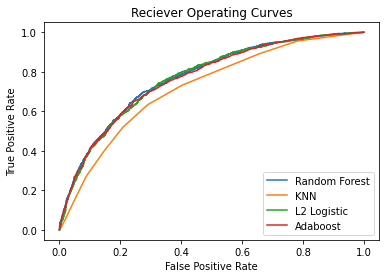

In [25]:
adaboost_probabilities = adaboost_clf.predict_proba(validation_data[features])
adaboost_probabilities = adaboost_probabilities[:, 1]

plt.title('Reciever Operating Curves')

fpr, tpr, threshold = roc_curve(validation_data[target], randomForest_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Random Forest')

fpr, tpr, threshold = roc_curve(validation_data[target], knn_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='KNN')

fpr, tpr, threshold = roc_curve(validation_data[target], l2_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='L2 Logistic')

fpr, tpr, threshold = roc_curve(validation_data[target], adaboost_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Adaboost')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend()
plt.savefig('roc_curves.png')

<div class="alert alert-block alert-success">
<h1>Get Prediction for Test</h1>
</div>

In [18]:
rain_test = pd.read_csv('seattle_rain_test.csv')

predictions = randomForest.predict(rain_test[features])

to_save = rain_test[['Id']].copy()
to_save.loc[:, 'Category'] = predictions
to_save.to_csv('submission.csv', index=False)